## Importing Data & Exploration

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
kc_housing = pd.read_csv('kc_house_data.csv')
kc_housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
kc_housing.isna().sum(), kc_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


(id                  0
 date                0
 price               0
 bedrooms            0
 bathrooms           0
 sqft_living         0
 sqft_lot            0
 floors              0
 waterfront       2376
 view               63
 condition           0
 grade               0
 sqft_above          0
 sqft_basement       0
 yr_built            0
 yr_renovated     3842
 zipcode             0
 lat                 0
 long                0
 sqft_living15       0
 sqft_lot15          0
 dtype: int64, None)

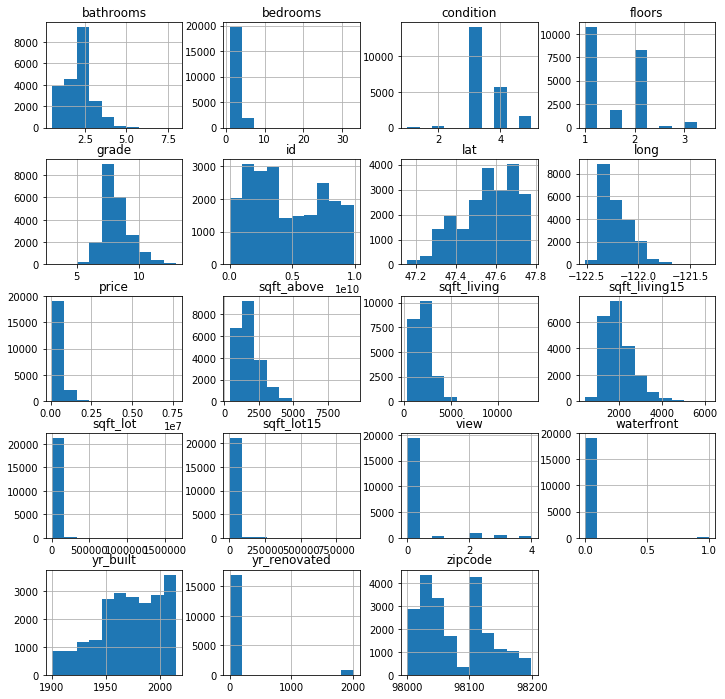

In [4]:
_ = kc_housing.hist(figsize=(12,12))

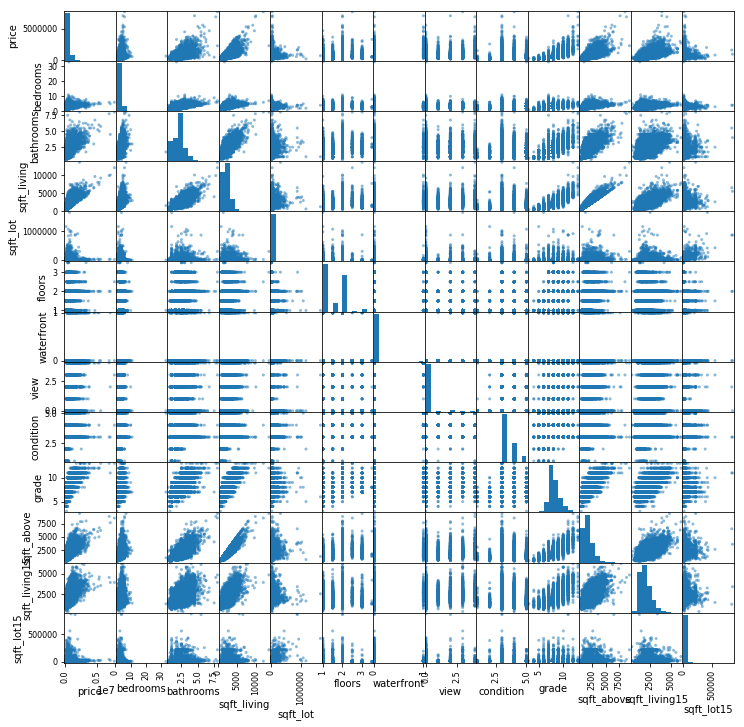

In [19]:
potential_cols = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors',
                     'waterfront', 'view','condition','grade','sqft_above','sqft_basement',
                     'sqft_living15','sqft_lot15']
    
_ = pd.plotting.scatter_matrix(kc_housing[potential_cols], figsize=(12,12))

### Scrubbing our data

#### Notes on data cleaning and organizing:
Dropping for now:
* Id: Does not feel necessary for our exploration and will drop this column
* Latitude & Longitude: for location purses, we are going to do some exploring with the ZIP code.
* Date: Going to use for some computations, but not do not need the variable on its own.

In [209]:
kc_measures = kc_housing.drop(['id','date','sqft_above','lat','long'], axis=1).copy()

Cleaning NaN values:
* Waterfront: data is both incomplete and appears to be very skewed. Since the value is already binary, we are marking all the NaN values negative for the time being to see if it provides any detail.
* Yr_renovated: To handle missing values, collapsing into binary for denoting renovation (True), or no value (False)
* Sqft_above: With ample other features for our property size, we decided to pass on using the characteristic for the time being. 
* Yr_built: this value on its own is not as helpful, but will use for some computation, so dropping for now.

In [210]:
kc_measures['waterfront'] = kc_measures['waterfront'].fillna(0.0)

kc_measures['renovated'] = np.where(kc_measures['yr_renovated']>0, 1, 0) 
kc_measures.drop('yr_renovated', axis=1, inplace=True)

kc_measures['view'] = kc_measures['view'].dropna(axis=0)
kc_measures['view'] = np.where(kc_measures['view']> 0, 1, 0)

Other data errors:
* Sqft_basement: In exploring this column, we found that some were marked with a question mark instead of a value. It appears that this column was a computation from sqft_living. Our decision was to test this variable as a binary value equating to having a basement(True), or no basement listed (False)

In [211]:
kc_measures['sqft_basement'] = kc_measures['sqft_basement'].str.replace('?', '0.0').astype('float')

In [212]:
kc_measures['basement'] = np.where(kc_measures['sqft_basement'] > 0, 1, 0)
kc_measures.drop('sqft_basement', axis=1, inplace=True)

Potential solutions for ZIP Code:
* Creating dummy variables for each individual ZIP code. This may subdivide things too much, but can expirment with it. 
* Trying a simple binary "In Seattle"-> True, "Not Seattle"-> False. A slimmer option, but might not provide the subltey of neighborhood variation.

In [213]:
df_zipcode_dums = pd.get_dummies(kc_measures['zipcode'])
kc_measures_wzip = pd.concat([kc_measures, df_zipcode_dums], axis=1)

In [214]:
# seattle_zips = [98101, 98102, 98104, 98105, 98108, 98109, 98112, 98113, 98114, 98117, 98103, 98106, 98107,
#                 98111, 98115, 98116, 98118, 98119,98121, 98125, 98126, 98132, 98133, 98138, 98139, 98141, 
#                 98122, 98124, 98127, 98129, 98131, 98134, 98136, 98144, 98145, 98148, 98155, 98160, 98161, 
#                 98164, 98165, 98168, 98170, 98146, 98154, 98158, 98166, 98174, 98175, 98178, 98190, 98191,
#                 98177, 98181, 98185, 98188, 98189, 98194, 98195, 98199,98198]

In [215]:
# kc_measures['in_seattle'] = kc_measures['zipcode'].map(lambda x: 1 if x in seattle_zips else 0)
# kc_measures.drop('zipcode', axis=1, inplace=True)

Potential uses of Year Built:
* Creating scalar values for column values for "newness" of yr_home_built (abs val from 1899 ref yr) from yr_built

In [216]:
kc_measures['yr_built_scalar_1899refyr'] = kc_measures['yr_built'].apply(lambda x: abs(1899-x))
kc_measures.drop('yr_built', axis=1, inplace=True)

Further notes:
* Bedrooms: The data appears complete, though has some heavy outliers on the higher end (one with 33 bedrooms!) which may need to be min-max standardized
* Bathrooms: Comporable to bedrooms, may need to be adjusted for outliers, but complete.
* Yr_built: To make this column more useful, we are going to convert it into its age in years (subtract current year)
* Yr_renovated: data is fairly incomplete, so might want to skip
* Sqft Living 15: Based on the graphs, it looks like we might find some helpful relationship
* Maybe yard size? Sqft_living - sqft_lot

In [217]:
kc_measures.columns
# Change name - yr_renovated_new',  'waterfront_new',  'view_new',

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'renovated', 'basement', 'yr_built_scalar_1899refyr'],
      dtype='object')

In [218]:
# Test for location close to expensive areas
# kc_measures['loc'] = (kc_measures['lat'] + 90) * (180 + kc_measures['long'])
# kc_measures.drop(['lat','long'], axis=1, inplace=True)
# # location = (lat + 90) * 180 + long

In [219]:
# downtown = (47.60806 + 90) * (180 + -122.33611)
# madrona = (47.613274 + 90) * (180 + -122.28887)
# slu = (47.62343 + 90) * (180 + -122.33435)
# eastlake = (47.64708 + 90) * ( 180 + -122.32477)
# queen_anne = (47.63692 + 90) * (180 + -122.35579)
# magnolia = (47.65056 + 90) * (180 + -122.40083)
# first_hill = (47.60864 + 90) *(180 + -122.32679)

# # #location = (lat + 90) * 180 + long

# kc_expensive = kc_housing.drop(['id','date','sqft_above'], axis=1).copy()
# kc_expensive['loc'] = (kc_measures['lat'] + 90) * (180 + kc_measures['long'])
# kc_expensive['loc_downtown'] = kc_expensive['loc'].apply(lambda x: x - downtown)
# kc_expensive['loc_madrona'] = kc_expensive['loc'].apply(lambda x: x - madrona)
# kc_expensive['loc_slu'] = kc_expensive['loc'].apply(lambda x: x - slu)
# kc_expensive['loc_eastlake'] = kc_expensive['loc'].apply(lambda x: x - eastlake)
# kc_expensive['loc_queen_anne'] = kc_expensive['loc'].apply(lambda x: x - queen_anne)
# kc_expensive['loc_magnolia'] = kc_expensive['loc'].apply(lambda x: x - magnolia)
# kc_expensive['loc_first_hill'] = kc_expensive['loc'].apply(lambda x: x - first_hill)

### Potential modelling based around categories of information:

* Size - sqft_living, sqft_lot, sqft_above, basement, sqft_lot15, sqft_living15, sqft
* Structure - bedrooms, bathrooms, floors, waterfront, view, condition, grade, renovated, basement
* Location - zipcode

In [220]:
#Linear regression with SKLearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [252]:
def lin_regress_summary(kc):

    X = kc.drop(['price'], axis=1)
    y = kc.price

    # Create train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Create model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Calculate our y hat (how our model performs against the test data held off)
    y_hat_test = model.predict(X_test)
    y_hat_test

    # See the R Squared score for our test data
    r2 = r2_score(y_test, y_hat_test)
    print(f"the r2 score is: {r2}")

    # See our Squared Mean Error score for data
    test_mse = mean_squared_error(y_test, y_hat_test)
    print(f"the test MSE is: {test_mse}")

    test_mse = np.sqrt(test_mse)
    print(f"the test RMSE is: {test_mse}")
    
    model = sm.OLS(y, X)
    results = model.fit()
    print(results.summary())

In [253]:
lin_regress_summary(kc_measures)

the r2 score is: 0.6350986308259646
the test MSE is: 51593861222.61949
the test RMSE is: 227142.82119983342
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:27:10   Log-Likelihood:            -2.9597e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:                   21582   BIC:                         5.921e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------

In [230]:
lin_regress_summary(kc_measures_wzip)

the r2 score is: 0.7949697327575247
the test MSE is: 30552474095.21154
the test RMSE is: 174792.66030131682


In [232]:
kc_m_update1 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'floors','view', 'condition',
                            'grade','sqft_living15', 'sqft_lot15']]

In [233]:
lin_regress_summary(kc_m_update1)

the r2 score is: 0.5841784467877664
the test MSE is: 55537441579.17935
the test RMSE is: 235663.83171623803


In [234]:
kc_m_update2 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view', 'condition', 'grade',
                            'zipcode', 'sqft_living15','sqft_lot15', 'renovated',
                            'basement', 'yr_built_scalar_1899refyr']]

In [235]:
lin_regress_summary(kc_m_update2)

the r2 score is: 0.6340737039309796
the test MSE is: 48207817755.93228
the test RMSE is: 219562.78773037175


In [236]:
kc_m_update3 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view', 'condition', 'grade', 'zipcode',
                            'sqft_living15','sqft_lot15',  'basement', 'yr_built_scalar_1899refyr']]

In [237]:
lin_regress_summary(kc_m_update3)

the r2 score is: 0.6165233087683544
the test MSE is: 55276747390.4771
the test RMSE is: 235110.07505097924


In [238]:
kc_m_update4 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot','view', 'condition', 'grade', 'sqft_living15',
                               'sqft_lot15','yr_built_scalar_1899refyr']]

In [239]:
lin_regress_summary(kc_m_update4)

the r2 score is: 0.6172362961701725
the test MSE is: 64658534830.04727
the test RMSE is: 254280.42557390704


In [240]:
kc_m_update5 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view',  'grade', 'sqft_living15',
                               'sqft_lot15', 'yr_built_scalar_1899refyr']]

In [241]:
lin_regress_summary(kc_m_update5)

the r2 score is: 0.6435845766725652
the test MSE is: 43598154900.130745
the test RMSE is: 208801.71191858256


In [242]:
kc_m_update6 = kc_measures[['price','bedrooms', 'bathrooms', 'sqft_living',
                            'condition', 'grade','basement', 'waterfront', 'view']]

In [243]:
lin_regress_summary(kc_m_update6)

the r2 score is: 0.6075400283845546
the test MSE is: 57796296097.3955
the test RMSE is: 240408.60237810854


In [250]:
kc_use = kc_measures[['price','waterfront', 'view', 'floors',
                      'sqft_living', 'grade', 'yr_built_scalar_1899refyr']]
kc_m_upate7 = pd.concat([kc_use, df_zipcode_dums], axis=1)

In [251]:
lin_regress_summary(kc_m_upate7)

the r2 score is: 0.7874399711081751
the test MSE is: 27070617450.650486
the test RMSE is: 164531.50899037693


In [196]:
kc_use = kc_measures[['price','sqft_living','bedrooms','bathrooms',
                      'grade', 'sqft_lot']]
kc_m_update8 = pd.concat([kc_use, df_zipcode_dums], axis=1)

In [197]:
lin_regress_summary(kc_m_update8)

the r2 score is: 0.7466503746654419
the test MSE is: 30711549651.900074
the test RMSE is: 175247.11025263747


In [246]:
kc_size = kc_measures[['price','sqft_living','sqft_lot','sqft_living15','sqft_lot15']]

In [247]:
lin_regress_summary(kc_size)

the r2 score is: 0.5173288096431243
the test MSE is: 64571031379.68822
the test RMSE is: 254108.3063964817


In [248]:
kc_structure = kc_measures[['price','bedrooms', 'bathrooms','floors',
                           'waterfront','view','condition', 'grade',
                           'renovated','basement']]

In [249]:
lin_regress_summary(kc_structure)

the r2 score is: 0.5580186646732435
the test MSE is: 62215764308.361435
the test RMSE is: 249430.88082344862


### Model fit testing

In [151]:
import statsmodels.api as sm

def stepwise_selection(df, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    y = df['price']
    X = df.drop('price', axis=1)
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

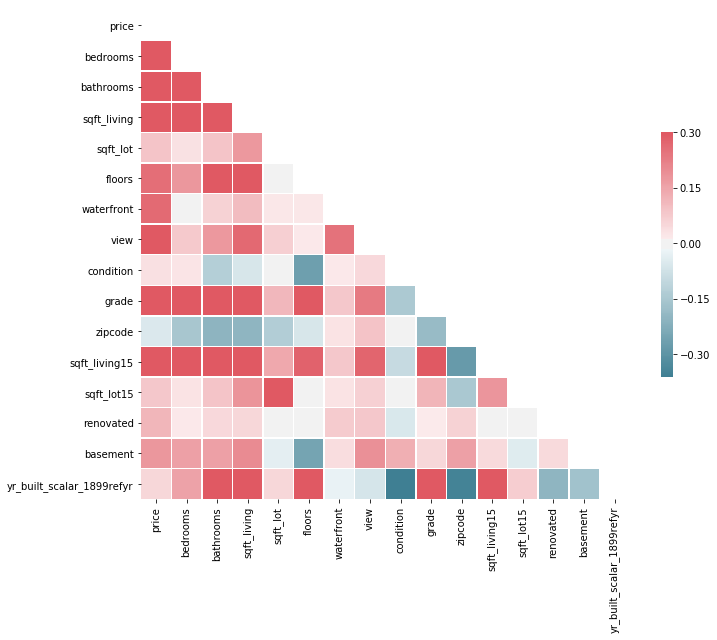

In [244]:
corr = kc_measures.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Looking for multicolinearity

From: https://seattle.curbed.com/2017/10/11/16462132/seattle-cheap-expensive-neighborhoods-buying-home

In [17]:
from sklearn import preprocessing
import statsmodels.api as sm

### Multivariate Linear Regression Models (Normalized just with Standard scalar, but not train-test split)

In [64]:
def ml_summary(df):
    
    scaler = preprocessing.StandardScaler()
    np_scaled = scaler.fit_transform(df)
    df_normalized = pd.DataFrame(np_scaled, columns=df.columns)
    
    y = df_normalized['price']
    X = df_normalized.drop('price', axis=1)
    
    predictors_int = sm.add_constant(X)
    model = sm.OLS(y, predictors_int).fit()
    print(model.summary())

SyntaxError: unexpected EOF while parsing (<ipython-input-64-ff6c256634b0>, line 13)

### Plotting practice

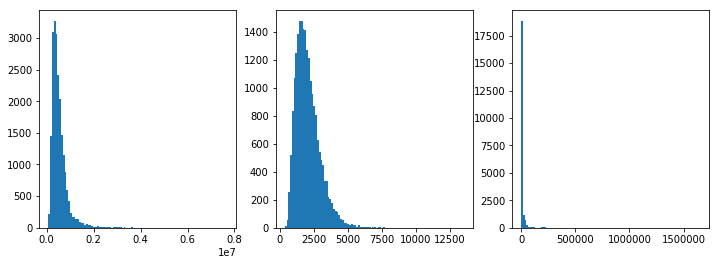

In [119]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

ax[0].hist(kc_measures['price'], bins=100)
ax[1].hist(kc_measures['sqft_living'], bins=100)
ax[2].hist(kc_measures['sqft_lot'], bins=100)
plt.show()

### Basic single linear model w/train-test split

In [126]:
scaler = preprocessing.StandardScaler()

X = scaler.fit_transform(kc_measures[['sqft_living']])
y = scaler.fit_transform(kc_measures[['price']])

/Users/nawjux/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nawjux/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [127]:
#Linear regression with SKLearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [128]:
# Create model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [129]:
# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = linreg.predict(X_test)

In [130]:
 # See the R Squared score for on our test data
r2 = r2_score(y_test, y_hat_test)

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
print(f"RMSE: {test_mse}\nR2: {r2}")

RMSE: 0.4618772247804854
R2: 0.47878756183209625


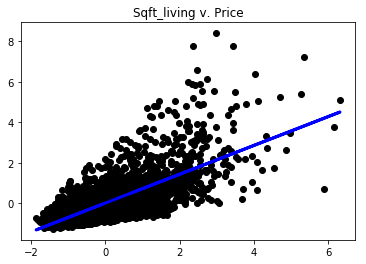

In [131]:
# Plotting
fig, ax = plt.subplots()
ax.scatter(X_test, y_test,  color='black')
ax.plot(X_test, y_hat_test, color='blue', linewidth=3)
ax.set_title('Sqft_living v. Price')
plt.show()

Setting up a shared repo
- Add contributor, 
- git clone, git checkout -b "directory" <- creates branch

In [150]:
result = stepwise_selection(kc_measures, verbose = True)
print('resulting features:')
print(result)

Add  waterfront                     with p-value 0.0
Add  view                           with p-value 0.0
Add  floors                         with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  sqft_living                    with p-value 0.0
Drop bathrooms                      with p-value 0.130218


/Users/nawjux/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  grade                          with p-value 0.0
Add  yr_built_scalar_1899refyr      with p-value 0.0
Add  bedrooms                       with p-value 5.36416e-56
Add  bathrooms                      with p-value 5.35875e-48
Add  sqft_lot15                     with p-value 1.63126e-21
Add  condition                      with p-value 1.87172e-14
Add  sqft_living15                  with p-value 1.06351e-11
Add  renovated                      with p-value 0.000874365
Add  basement                       with p-value 0.00897782
resulting features:
['waterfront', 'view', 'floors', 'sqft_living', 'grade', 'yr_built_scalar_1899refyr', 'bedrooms', 'bathrooms', 'sqft_lot15', 'condition', 'sqft_living15', 'renovated', 'basement']


* Need to check for multicollinearity 
* Seeing effect of outliers
* What about a location makes it more valuable than others, dummy for zip codes 
* Dollar per square foot
* Distance from Seattle, convert into single value by Lat-Long, calculate distance from 
* Potentially convert scale based to improve values
* When normalizing, don't lose track of the values and what they mean
* NBDime - needed to merge Jupyter notebooks
* R squared is for representation of data, but not generalize, look at test error, RMSE, MAE, RMSLE, pick baseline error, pick metric based on business problem. 
* model.score is good for getting RMSE, but don't limit yourself to that
* Cross validation will answer the question of whether to use more or less of a value
* Stick with RMSE Sklearn, feature selection 

In [ ]:
log transform of price, 